In [1]:
!pip install -q timm

In [2]:
!unzip data.zip

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Variables

In [3]:
class VARIABLES:
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = 'resnext50_32x4d'
    size = 128
    scheduler = 'CosineAnnealingWarmRestarts'
    epochs = 8
    T_0 = 10
    lr = 1e-3
    min_lr = 1e-4
    batch_size = 64
    weight_decay = 1e-1
    gradient_accumulation_steps=1
    seed = 42
    target_size = 5
    target_col = 'predominant_stress'
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]

### Libraries

In [4]:
# Download model
import sys
sys.path.append('./input/pytorch-image-models-master')

import os
import random
import numpy as np
import pandas as pd

# For data visualization and image handling
import cv2
import matplotlib.pyplot as plt

# For evaluation and cross validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# For the model ResNet50
import timm

# Pytorch libraries for modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# For image preprocessing
from albumentations.pytorch import ToTensorV2
from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, Transpose)

import warnings
warnings.filterwarnings('ignore')

if VARIABLES.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Import Files
  
  Predominant biotic stress on the leaf.

	Possible values:
	  0 - healthy
	  1 - miner
	  2 - rust
	  3 - phoma
	  4 - cercospora


In [5]:
# import labeled csv file
labels = pd.read_csv("data/dataset.csv")
labels = labels.iloc[:, :2]
labels = labels[labels['predominant_stress'] != 5]
labels.head()

,id,predominant_stress
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [6]:
# Split the DataFrame into train and test sets
train, test = train_test_split(labels, test_size=0.2, random_state=42)

print("Train size: ", len(train['id'].values))
print("Test size: ", len(test['id'].values))

display(train.head())
display(test.head())

Train size:  1348
Test size:  337


,id,predominant_stress
1733,1734,2
513,514,3
163,164,2
1193,1194,0
946,947,0


,id,predominant_stress
1213,1214,4
1180,1181,0
568,569,4
49,50,1
1563,1564,2


##### Number of Images for Each Class

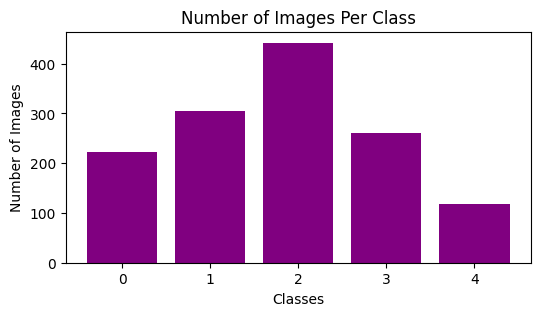

In [7]:
# graph the quantity of images for each class
df_classes = train.groupby(['predominant_stress']).count().reset_index()
plt.figure(figsize=(6, 3))
plt.bar(df_classes['predominant_stress'], df_classes['id'], color='purple')
plt.ylabel('Number of Images')
plt.xlabel('Classes')
plt.title('Number of Images Per Class')
plt.show()

####  Prepare Data for Training

In [8]:
# Prepare the data for training

class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['id'].values
        self.labels = df['predominant_stress'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        label = self.labels[idx]
        file_path = f'data/images/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # transform the data
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(label).long()
        return image, label

#### Prepare Data for Testing

In [9]:
# Prepare the data for testing

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['id'].values
        self.labels = df['predominant_stress'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        label = self.labels[idx]
        file_path = f'data/images/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # transform the data
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

#### Transform Data

In [10]:
from albumentations import Compose, Resize, HorizontalFlip, Sharpen

# Transform the data
def get_transforms(*, data):
     # If the data is for training, proceed with the following transformations

    if data == 'train':
        return Compose([
            Resize(VARIABLES.size, VARIABLES.size),
            HorizontalFlip(p=0.5),
            Sharpen(alpha=(0.1, 0.2), lightness=(1.0, 1.4), p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    # If the data is for testing, perform minor transformations
    elif data == 'valid':
        return Compose([
            Resize(VARIABLES.size, VARIABLES.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

### Visualization

#### Training Data (Before Transformations)

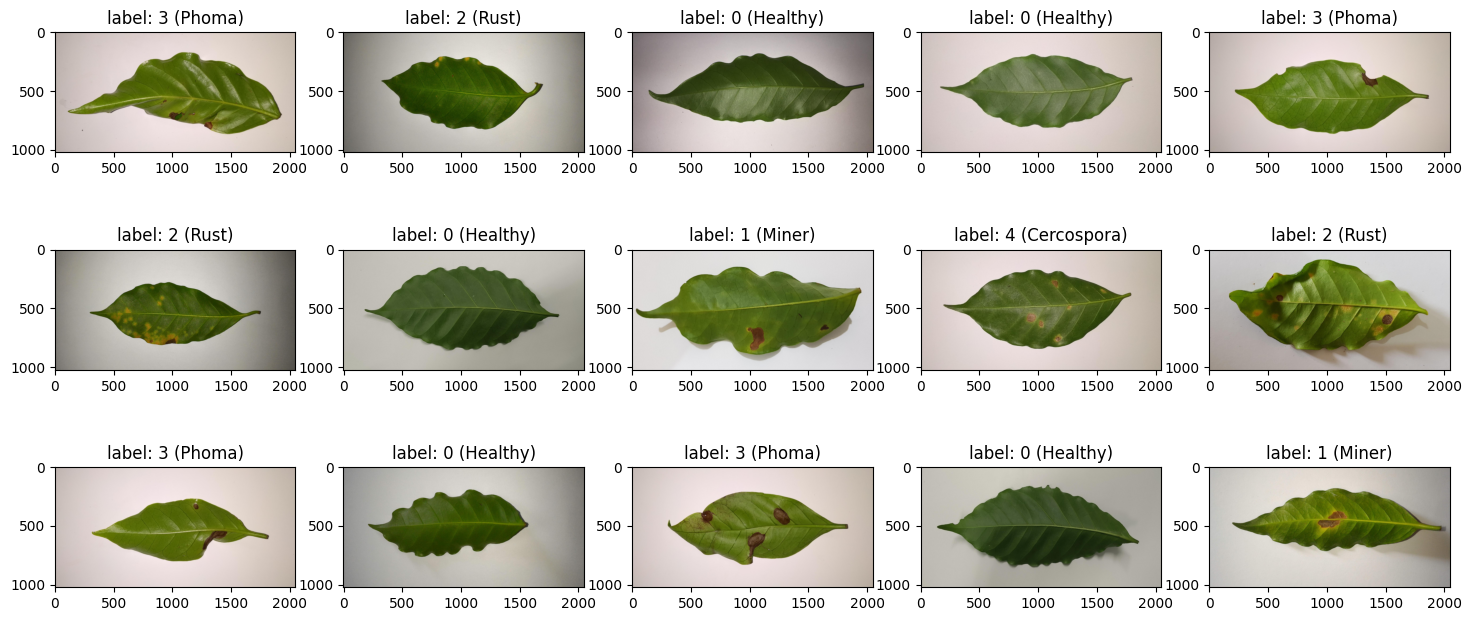

In [11]:
train_dataset = TrainDataset(train, transform=None)

# dictionary to get the name for each category
category_dictionary = {0 : 'Healthy' , 1: 'Miner' , 2: 'Rust', 3: 'Phoma' , 4: 'Cercospora'}

# number of rows, columns and images to plot
c, r = 5, 3
images = c * r
fig = plt.figure(figsize=(18, 8))

for i in range(1, images + 1):
    image, label = train_dataset[i]
    name = category_dictionary[label.item()]
    fig.add_subplot(r, c, i)
    plt.imshow(image)
    plt.title(f'label: {label} ({name})')
plt.show()

#### Training Data (After Transformations)

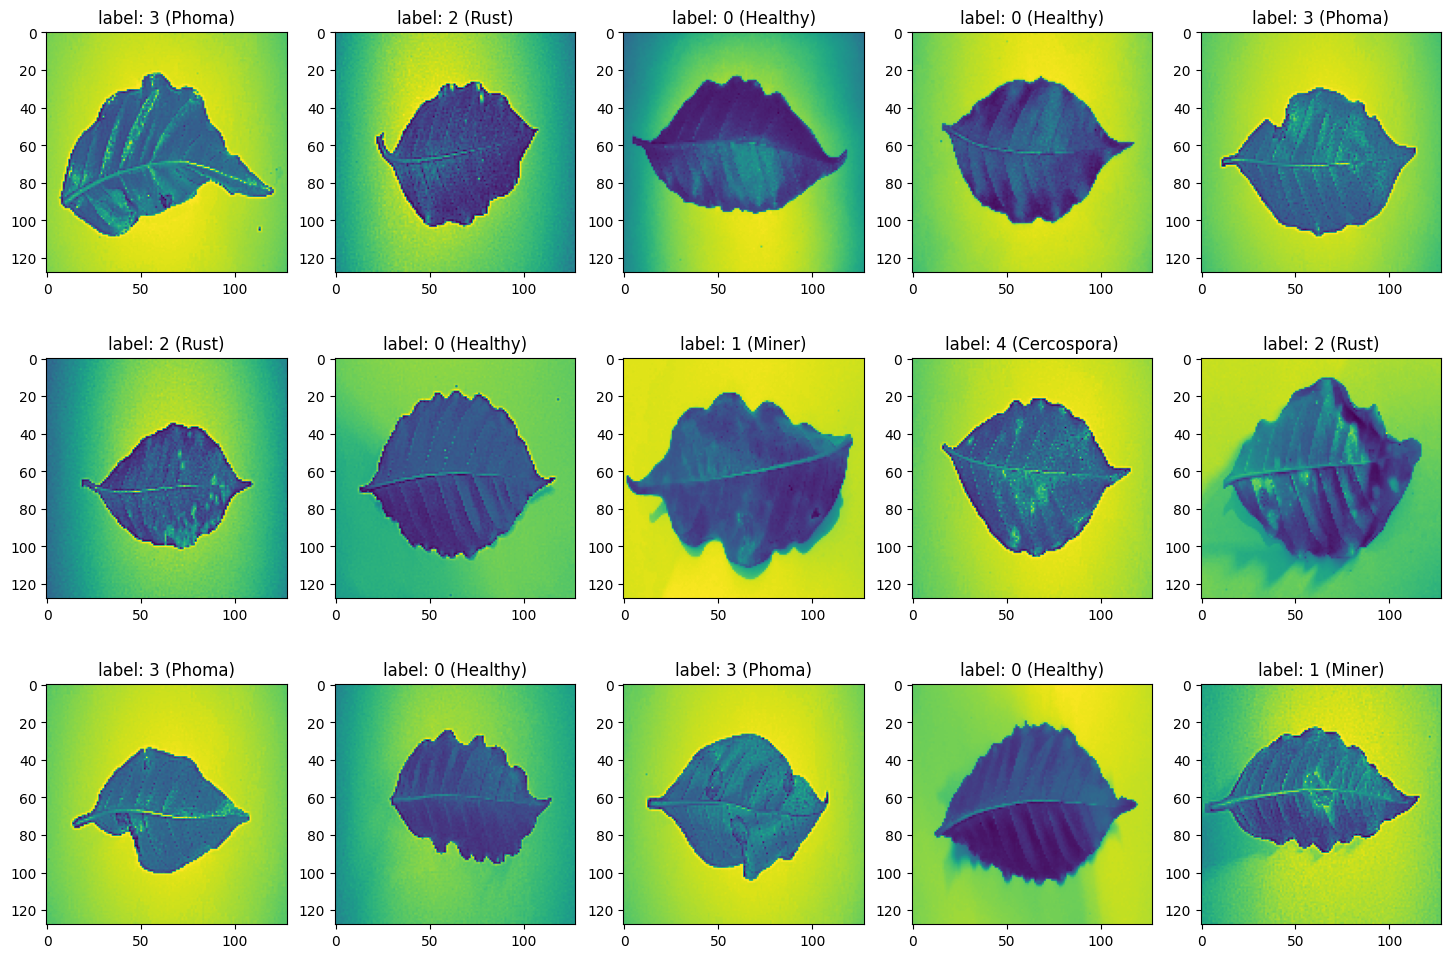

In [12]:
# plot the same figures after transformation
fig = plt.figure(figsize=(18, 12))

for i in range(1, images + 1):
  train_dataset = TrainDataset(train[i:i+1], transform=get_transforms(data='train'))
  image, label = train_dataset[0]
  name = category_dictionary[label.item()]
  fig.add_subplot(r, c, i)
  plt.imshow(image[0])
  plt.title(f'label: {label} ({name})')
plt.show()

### Helper Functions

In [13]:
# Calculates and save the average and current value
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Calculate the accuracy score
def get_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=VARIABLES.seed)

### Cross Validation

In [14]:
folds = train.copy().reset_index(drop=True)

assert VARIABLES.target_col in folds.columns, "Target column not found in DataFrame"

Fold = StratifiedKFold(n_splits=VARIABLES.n_fold, shuffle=True, random_state=VARIABLES.seed)

for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[VARIABLES.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

print(folds.groupby(['fold', VARIABLES.target_col]).size())

fold  predominant_stress
0     0                     45
      1                     60
      2                     89
      3                     52
      4                     24
1     0                     44
      1                     61
      2                     89
      3                     52
      4                     24
2     0                     44
      1                     61
      2                     88
      3                     53
      4                     24
3     0                     45
      1                     61
      2                     88
      3                     52
      4                     23
4     0                     45
      1                     61
      2                     88
      3                     52
      4                     23
dtype: int64


### Model

In [15]:
# ResNext 50_32x4d Model
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, VARIABLES.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
# test the model to see if works
model = CustomResNext(model_name = VARIABLES.model_name, pretrained = False)
train_dataset = TrainDataset(train, transform = get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True,
                          num_workers = 4, pin_memory = True, drop_last = True)
# print the outcome
for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.1644,  0.1062,  0.0830,  0.3875,  0.1056],
        [ 0.0924,  0.0507, -0.0178,  0.4982,  0.1392],
        [ 0.0682,  0.0056,  0.0066,  0.4632, -0.0344],
        [ 0.1429,  0.0655,  0.1233,  0.4413, -0.0075]],
       grad_fn=<AddmmBackward0>)


In [28]:
print(model)

CustomResNext(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d

#### Train

In [17]:
# Function to train the model

def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    losses = AverageMeter()
    scores = AverageMeter()

    # Switch to train mode
    model.train()
    global_step = 0

    # Iterate over the images and labels
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)

        # Record loss
        losses.update(loss.item(), batch_size)
        if VARIABLES.gradient_accumulation_steps > 1:
            loss = loss / VARIABLES.gradient_accumulation_steps

        #  Scale the loss before it is backpropagated through the NN and updated using an optimizer
        if VARIABLES.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
          loss.backward()

        # If true, the accumulated gradients are ready to be used
        if (step + 1) % VARIABLES.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

        # Print iterations of the epochs based on frequency
        if step % VARIABLES.print_freq == 0 or step == (len(train_loader)-1):
            print('Train: [{0}/{1}] '
                  'Loss: {loss.val:.4f} Loss Avg: {loss.avg:.4f} '
                  .format(step, len(train_loader), loss=losses,))
    return losses.avg


#### Validation

In [18]:
# Function to evaluate the model

def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    scores = AverageMeter()

    # Switch to eval mode
    model.eval()
    preds = []

    # Iterate over the images and labels
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # Compute loss
        with torch.no_grad():
            y_preds = model(images)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # Record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if VARIABLES.gradient_accumulation_steps > 1:
            loss = loss / VARIABLES.gradient_accumulation_steps

        # Print iterations of the epochs based on frequency
        if step % VARIABLES.print_freq == 0 or step == (len(valid_loader)-1):
            print('Eval: [{0}/{1}] '
                  'Loss: {loss.val:.4f} Loss Avg: {loss.avg:.4f}'
                  .format(step, len(valid_loader), loss=losses,))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

#### Test

In [19]:
from tqdm.auto import tqdm

def test_fn(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    # iterate over the images
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        # iterate over the states and start to evaluate
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                # get the predictions
                y_preds = model(images)
            # append to the array the predictions after softmax
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        # get the average prediction
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

#### Fold Loop

In [20]:
OUTPUT_DIR = './'

# Run function for each fold
def fold_loop(folds, fold):

    avg_loss_epochs = []
    avg_val_loss_epochs = []

    # Get the indices for the folds
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    # Get the items from the data using the indices
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    # Prepare the data for training and testing
    train_dataset = TrainDataset(train_folds,
                                 transform = get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds,
                                 transform = get_transforms(data='valid'))

    # Feed the dataloader with the data prepared
    train_loader = DataLoader(train_dataset,
                              batch_size = VARIABLES.batch_size, shuffle = True,
                              num_workers = VARIABLES.num_workers, pin_memory = True, drop_last = True)

    valid_loader = DataLoader(valid_dataset,
                              batch_size = VARIABLES.batch_size, shuffle = False,
                              num_workers = VARIABLES.num_workers, pin_memory = True, drop_last = False)

    # Use the ResNext model for modeling
    model = CustomResNext(VARIABLES.model_name, pretrained = True)
    model.to(device)

    # Use Adam optimizer
    optimizer = Adam(model.parameters(), lr=VARIABLES.lr, weight_decay=VARIABLES.weight_decay, amsgrad=False)

    # The scheduler can be used to adjust the learning rate at each epoch or step
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=VARIABLES.T_0, T_mult=1, eta_min=VARIABLES.min_lr, last_epoch=-1)

    # If true, Apex integration is enabled
    if VARIABLES.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # Loss function
    criterion = nn.CrossEntropyLoss()
    best_accuracy = 0.

    print(f"Fold: {fold + 1}")
    print("_______________________________")

    # Iterate over the epochs
    for epoch in range(VARIABLES.epochs):

        print(f"\nEpoch: {epoch + 1}")
        print("-------------------------------")

        # Start training
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        # Start evaluating
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        # Get the valid labels
        valid_labels = valid_folds[VARIABLES.target_col].values

        scheduler.step()

        # Get the accuracy
        accuracy  = get_accuracy(valid_labels, preds.argmax(1))

        avg_loss_epochs.append(avg_loss)
        avg_val_loss_epochs.append(avg_val_loss)

        print(f"Accuracy: {accuracy}%, Avg Train Loss: {avg_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

        # If the accuracy is higher than the best accuracy, save the model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f'Save Best Score: {best_accuracy:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        OUTPUT_DIR+f'{VARIABLES.model_name}_fold{fold}_best.pth')

    check_point = torch.load(OUTPUT_DIR+f'{VARIABLES.model_name}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, avg_loss_epochs, avg_val_loss_epochs


### Results

In [21]:
# Get the accuracy of each fold or all the folds combined
def get_result(result_df):
  preds = result_df['preds'].values
  labels = result_df[VARIABLES.target_col].values
  accuracy = get_accuracy(labels, preds)
  return accuracy


avg_loss_list = []
avg_val_loss_list = []

# Iterate over all the folds and store the results into a df
result_df = pd.DataFrame()
for fold in range(VARIABLES.n_fold):
  if fold in VARIABLES.trn_fold:
    fold_df, avg_loss_epochs, avg_val_loss_epochs = fold_loop(folds, fold)
    result_df = pd.concat([result_df, fold_df])
    fold_accuracy = get_result(fold_df)
    print(f'Fold Accurary: {fold_accuracy:<.4f}')
    print("_______________________________")

    # append loss into the list
    avg_loss_list.append(avg_loss_epochs)
    avg_val_loss_list.append(avg_val_loss_epochs)

    # Accuracy result for all the folds result
    final_accuracy = get_result(result_df)
    print(f'Final Accurary: {final_accuracy:<.4f}')
    print("_______________________________")

Fold: 1
_______________________________

Epoch: 1
-------------------------------
Train: [0/16] Loss: 1.6134 Loss Avg: 1.6134 
Train: [15/16] Loss: 1.4127 Loss Avg: 1.4803 
Eval: [0/5] Loss: 1.3760 Loss Avg: 1.3760
Eval: [4/5] Loss: 1.2467 Loss Avg: 1.4512
Accuracy: 0.42962962962962964%, Avg Train Loss: 1.4803, Avg Val Loss: 1.4512
Save Best Score: 0.4296 Model

Epoch: 2
-------------------------------
Train: [0/16] Loss: 1.3122 Loss Avg: 1.3122 
Train: [15/16] Loss: 1.1218 Loss Avg: 1.2572 
Eval: [0/5] Loss: 1.1707 Loss Avg: 1.1707
Eval: [4/5] Loss: 1.1889 Loss Avg: 1.2667
Accuracy: 0.5074074074074074%, Avg Train Loss: 1.2572, Avg Val Loss: 1.2667
Save Best Score: 0.5074 Model

Epoch: 3
-------------------------------
Train: [0/16] Loss: 1.0468 Loss Avg: 1.0468 
Train: [15/16] Loss: 0.6244 Loss Avg: 0.8706 
Eval: [0/5] Loss: 1.1694 Loss Avg: 1.1694
Eval: [4/5] Loss: 0.9572 Loss Avg: 1.2036
Accuracy: 0.6481481481481481%, Avg Train Loss: 0.8706, Avg Val Loss: 1.2036
Save Best Score: 0.6

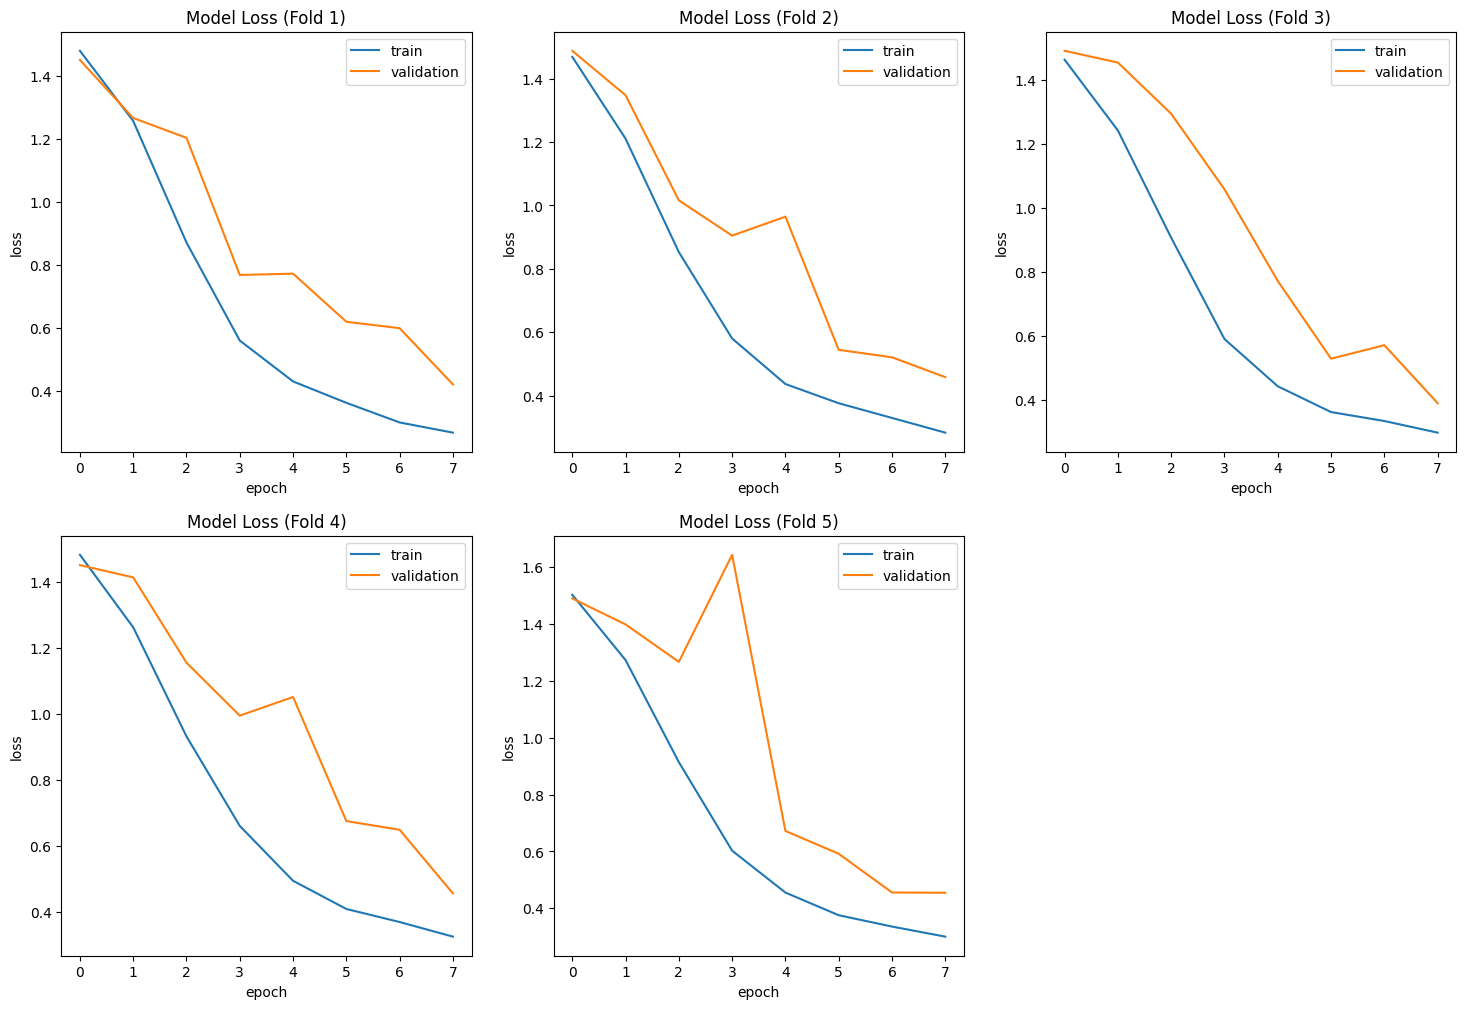

In [25]:
# Plot the loss for each fold
c, r = 3, 2
fig = plt.figure(figsize=(18, 12))
for i in range(VARIABLES.n_fold):
    fig.add_subplot(r, c, i+1)
    plt.plot(avg_loss_list[i])
    plt.plot(avg_val_loss_list[i])
    plt.title(f'Model Loss (Fold {i+1})')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'validation'], loc='best')
plt.show()

In [26]:
# Test
model = CustomResNext(VARIABLES.model_name, pretrained=False)
states = [torch.load(OUTPUT_DIR+f'{VARIABLES.model_name}_fold{fold}_best.pth') for fold in VARIABLES.trn_fold]
test_dataset = TestDataset(test, transform = get_transforms(data='valid'))

test_loader = DataLoader(test_dataset, batch_size = VARIABLES.batch_size, shuffle = False,
                                 num_workers = VARIABLES.num_workers, pin_memory = True)
# Get the predictions
predictions = test_fn(model, states, test_loader, device)

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
y_pred = test.copy()
y_pred['predominant_stress'] = predictions.argmax(1)

# test is y_true, and y_pred is y_pred
accuracy = accuracy_score(test['predominant_stress'], y_pred['predominant_stress']) * 100
print(f'Accuracy Test: {accuracy}%')

Accuracy Test: 88.4272997032641%
